This Google Colab notebook is based on the Kaggle notebook here: https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data, which is linked from Chapter 1 of the fast.ai Practical Deep Learning course. The original version uses a different image search library which seems to not work consistently.

## Is it a bird?

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities

!pip install -U duckduckgo_search
!pip install fastai
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.6/253.6 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 4.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 3.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 13.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 34.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 25.9 MB/s eta 0:00:0000:0100:01
     ━━━

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

![image.png](https://imgs.xkcd.com/comics/tasks_2x.png)

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [2]:
from fastbook import *
from fastai.vision.widgets import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images=max_images))


Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get an error, you can skip this cell, which is just to peek at the first image.
urls = search_images('car photos', max_images=1)
urls[0]

Searching for 'car photos'


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:1007)>

...and then download a URL and take a look at it:

In [ ]:
from fastdownload import download_url
dest = 'car.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


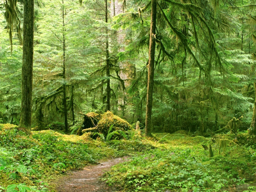

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get an error, you can skip this cell, which is just to peek at the first image.

download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [ ]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [ ]:
print(path)
searches = 'forest','bird'

for imageType in searches:
    print(imageType)
    content = os.listdir(path/imageType)
    for element in content:
        print(element)

bird_or_not
forest
a595b1f5-b51a-4cd0-b27b-c12172416590.jpg
8d3bfeb7-9299-45c5-b59b-639a414d3972.jpg
ad378635-0a2a-4ddb-824c-5b8e48c8d0a1.jpg
05693d42-da6a-4ced-a749-e6459d386692.png
400e394a-66f7-40aa-9d14-b57ea69a7f23.jpg
484e3617-6665-49c1-b537-c1ae7783b43f.jpg
678e16c4-8f39-4262-9e84-ec07096d578f.jpg
caa3725e-01b0-4cbe-88a8-d0072afb157e.jpg
c1ce0838-f22d-496f-9a3c-597e948a55f8.jpg
4486729e-f8cf-48da-85e8-1fa0d747d9f3.jpg
45a9e0b9-6096-4883-bdea-7fe0248e4e01.jpg
40f31417-58aa-40b1-8c53-59a5f3757426.jpg
7d399839-c16b-4ec6-930b-d5894c2df5cc.jpg
8c57313e-e3c7-4b58-b7d4-f95803107b66.jpg
0b6ef0cc-936e-4029-998c-c646b475154d.png
e9ab866b-a199-4157-a78b-31f17c63a4fc.jpg
168987af-7e1c-44a0-9aa1-b730bdceb203.JPG
2856d25f-e715-4a82-be21-f85b41efb2c5.jpg
3ad12aa7-2003-4894-8df8-701ce5a285eb.jpg
99876d1b-d736-49ec-b20e-dda962163d9d.jpg
95442d77-9ea2-40e7-8366-9f9c4dc47431.jpg
270fbbbb-97f8-4842-afd0-1fb2abe1e147.jpg
36f3b35d-de43-4e80-a0f3-7068b95b7da8.jpg
ac882848-3ab3-440d-89ed-54603f37563f.j

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

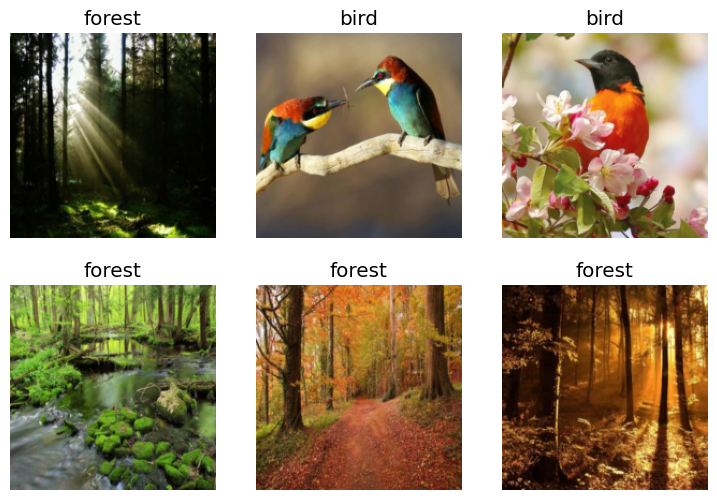

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


Initial error rate: 0.4545454680919647


epoch,train_loss,valid_loss,error_rate,time
0,1.074077,0.521309,0.272727,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.260877,0.078153,0.030303,00:01
1,0.150944,0.085982,0.030303,00:00
2,0.102644,0.111546,0.030303,00:01


Error rate after fine-tuning: 0.03030303120613098


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Save this notebook to your own Google Drive and try creating your own image classifier using your own image searches!